In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from data import RoadSatelliteModule
from system import SemanticSegmentationSystem

from models import *

import numpy as np
import matplotlib.pyplot as plt
import random

import torchvision
import torchvision.transforms.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import torch
from torchinfo import summary

import regex as re

# 1. Preparation

In [11]:
batch_size = 8
num_workers = 8

In [12]:
pl.seed_everything(7, workers=True)

Global seed set to 7


7

## 1.1 DataModule

In [13]:
road_data = RoadSatelliteModule(num_workers=num_workers, batch_size=batch_size)

In [14]:
%%time
X, y = next(iter(road_data.train_dataloader()))

CPU times: user 8.09 ms, sys: 111 ms, total: 119 ms
Wall time: 866 ms


In [15]:
X.shape

torch.Size([8, 3, 160, 160])

## 1.2 Inspect Data

In [16]:
def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

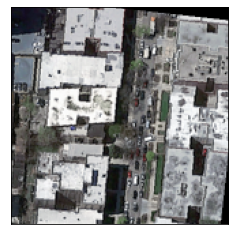

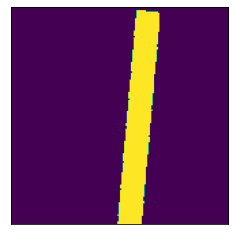

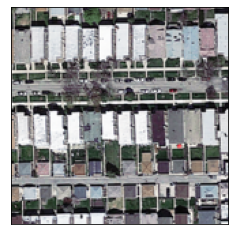

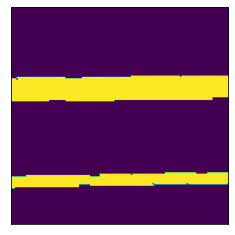

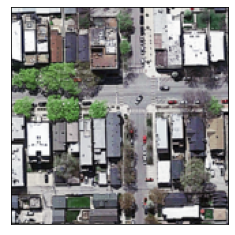

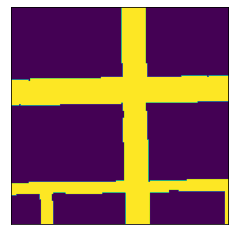

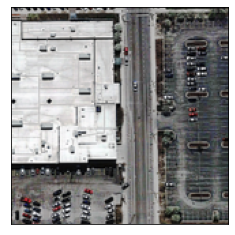

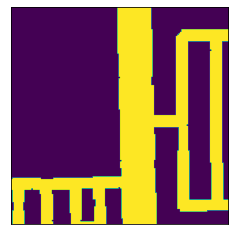

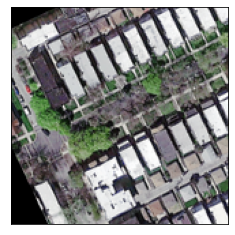

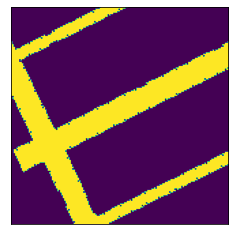

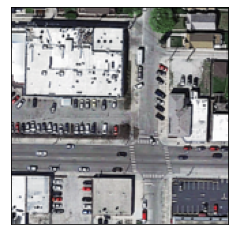

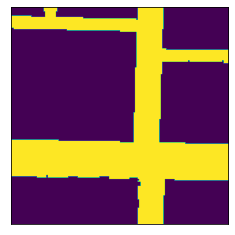

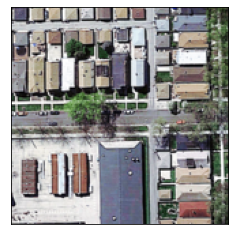

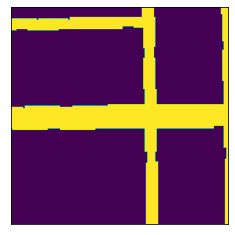

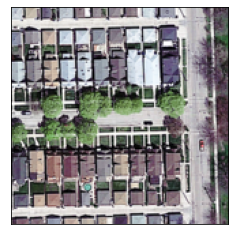

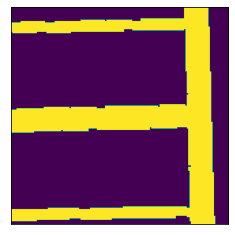

In [17]:
for x, v in zip(X, y):
    show_image(x)
    show_image(v)

# 2. Define Model / System

In [10]:
model = UNet(1, 3)
model_name = str(model).partition('(')[0]

In [11]:
system = SemanticSegmentationSystem(model, road_data)

In [12]:
#system = SemanticSegmentationSystem.load_from_checkpoint(f'./lightning_logs/{model_name}.ckpt', model=model, datamodule=road_data)

In [13]:
summary(model, input_size=(8, 3, 160, 160))

/cluster/home/mboss/.virtualenvs/mp-env/lib64/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     --                        --
├─VGGBlock: 1-1                          [8, 16, 160, 160]         --
│    └─Conv2d: 2-1                       [8, 16, 160, 160]         448
│    └─BatchNorm2d: 2-2                  [8, 16, 160, 160]         32
│    └─ReLU: 2-3                         [8, 16, 160, 160]         --
│    └─Conv2d: 2-4                       [8, 16, 160, 160]         2,320
│    └─BatchNorm2d: 2-5                  [8, 16, 160, 160]         32
│    └─ReLU: 2-6                         [8, 16, 160, 160]         --
├─MaxPool2d: 1-2                         [8, 16, 80, 80]           --
├─VGGBlock: 1-3                          [8, 32, 80, 80]           --
│    └─Conv2d: 2-7                       [8, 32, 80, 80]           4,640
│    └─BatchNorm2d: 2-8                  [8, 32, 80, 80]           64
│    └─ReLU: 2-9                         [8, 32, 80, 80]           --
│    └─C

In [14]:
if torch.cuda.is_available():
    gpu_count = -1
    gpu_auto_select = True
    print("GPUs detected.")
    print("There should be ", torch.cuda.device_count(), " GPUs available.")
else:
    gpu_count = 0
    gpu_auto_select = False
    print("No GPU detected.")
    print("Working with CPU")

gpu_count

GPUs detected.
There should be  1  GPUs available.


-1

# 4. Training

In [15]:
checkpoint_callback = ModelCheckpoint(
    monitor='validation_accuracy',
    dirpath='./lightning_logs',
    filename=model_name,
    save_top_k=1,
    verbose=2,
    mode='max'
)

/cluster/home/mboss/.virtualenvs/mp-env/lib64/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Checkpoint directory ./lightning_logs exists and is not empty.
  warnings.warn(*args, **kwargs)


In [16]:
early_stop_callback = EarlyStopping(
   monitor='validation_accuracy',
   patience=60,
   verbose=1,
   mode='max'
)

In [17]:
trainer = pl.Trainer(
    #fast_dev_run=True,
    gpus=gpu_count,
    auto_select_gpus=gpu_auto_select,
    stochastic_weight_avg=True,
    benchmark=True,
    callbacks=[early_stop_callback, checkpoint_callback]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
%%time
trainer.fit(system)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type     | Params
-----------------------------------------
0 | model       | UNet     | 2.0 M 
1 | dice_loss   | DiceLoss | 0     
2 | upsample2x  | Upsample | 0     
3 | upsample608 | Upsample | 0     
-----------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.862     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 7


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved. New best score: 0.378
Epoch 0, global step 9: validation_accuracy reached 0.37836 (best 0.37836), saving model to "/cluster/home/mboss/cil_2021/lightning_logs/UNet-v5.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.308 >= min_delta = 0.0. New best score: 0.686
Epoch 1, global step 19: validation_accuracy reached 0.68594 (best 0.68594), saving model to "/cluster/home/mboss/cil_2021/lightning_logs/UNet-v5.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.016 >= min_delta = 0.0. New best score: 0.702
Epoch 2, global step 29: validation_accuracy reached 0.70236 (best 0.70236), saving model to "/cluster/home/mboss/cil_2021/lightning_logs/UNet-v5.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.710
Epoch 3, global step 39: validation_accuracy reached 0.70989 (best 0.70989), saving model to "/cluster/home/mboss/cil_2021/lightning_logs/UNet-v5.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.073 >= min_delta = 0.0. New best score: 0.782
Epoch 4, global step 49: validation_accuracy reached 0.78241 (best 0.78241), saving model to "/cluster/home/mboss/cil_2021/lightning_logs/UNet-v5.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.784
Epoch 5, global step 59: validation_accuracy reached 0.78442 (best 0.78442), saving model to "/cluster/home/mboss/cil_2021/lightning_logs/UNet-v5.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.790
Epoch 6, global step 69: validation_accuracy reached 0.79027 (best 0.79027), saving model to "/cluster/home/mboss/cil_2021/lightning_logs/UNet-v5.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 79: validation_accuracy was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 89: validation_accuracy was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 99: validation_accuracy was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 109: validation_accuracy was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 119: validation_accuracy was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 129: validation_accuracy was not in top 1


In [ ]:
if gpu_count != 0:
    model.cuda()

In [ ]:
system.visualize_results()

In [ ]:
system.visualize_results_overlay()

# Predict test

In [ ]:
trainer.test()

In [ ]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def mask_to_patched_mask(image):
    patched_image = image.squeeze().detach().clone()
    image = np.asarray(image.squeeze())
    patch_size = 16
    for j in range(0, image.shape[1], patch_size):
        for i in range(0, image.shape[0], patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            patched_image[i:i + patch_size, j:j + patch_size] = label
    return patched_image

def mask_to_submission_strings(im, name):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", name).group(0))
    #im = mpimg.imread(image_filename) 
    # image is gray scale therefore size MxN with imread 
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *images):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for imgs, fn in images[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(imgs, fn))

In [ ]:
batches = system.test_results

In [ ]:
submission_filename = model_name + '_predictions.csv'
pred_counter = 0

In [ ]:
with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        
        for mask, name in system.test_results:
            predicted_mask = np.asarray(mask.cpu().squeeze())

            ids = mask_to_submission_strings(predicted_mask, name)
            f.writelines('{}\n'.format('\n'.join(ids)))

            pred_counter += 1
pred_counter